In [57]:
library(rethinking)
data(Primates301)
d <- Primates301
cc <- complete.cases( d$brain , d$body )

B <- d$brain[cc]
M <- d$body[cc]
B <- B / max(B)
M <- M / max(M)

In [58]:
Bse <- B*0.1
Mse <- M*0.1

In [59]:
dat_list <- list(
                B = B,
                M = M )

m1.1 <- ulam(
            alist(
            B ~ dlnorm( mu , sigma ),
            mu <- a + b*log(M),
            a ~ normal(0,1),
            b ~ normal(0,1),
            sigma ~ exponential(1)
            ) , data=dat_list, cores=4, chains=4 )

recompiling to avoid crashing R session


In [4]:
precis(m1.1)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.4280446,0.05929671,0.3275408,0.5251351,644.6563,0.9996852
b,0.7834222,0.01448596,0.7599440,0.8075000,676.0480,0.9994965
sigma,0.2941727,0.01605932,0.2697608,0.3203682,1052.2222,1.0048503


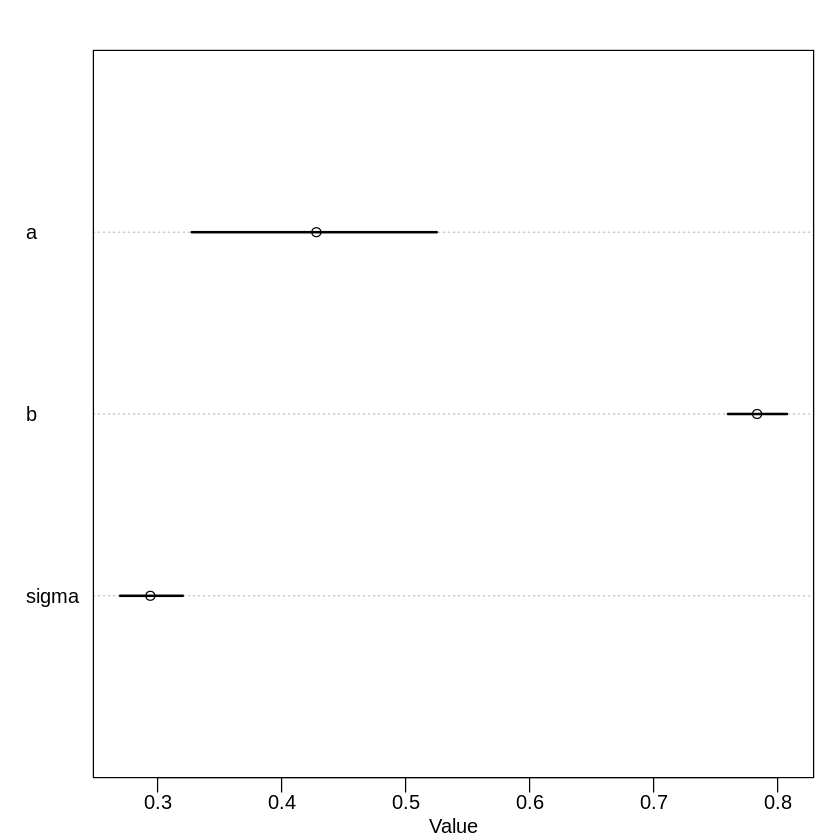

In [5]:
plot(precis(m1.1))

In [6]:
mean(M)

[1] 0.05807951

In [7]:
sd(M)

[1] 0.1196015

In [8]:
dat_listSE <- list(
                    B = B,
                    M = M,
                    Bse = Bse,
                    Mse = Mse,
                    N = sum(cc),
                    meanM = 0.06
#                     , sdM = 0.12
                )

m1.1se <- ulam(     # ulam may experience a missing variable "i" error depending on where you put the link line containing [i].  Do we need to add i to the data(?) - no, it still doesn't work...  Compare this to m15.2 in Chapter 15, where i is used without definition.
# m1.1se <- map2stan(
            alist(
                B ~ dnorm( B_true, Bse ),
                vector[N]: B_true ~ dlnorm( mu , sigma ),
            
                mu <- a + b*log(M_true[i]), # ulam may experience a missing variable "i" error depending on where you put the link line containing [i].  stan2map doesn't seem to be so fragile in the order of the lines.
#                 mu <- a + b*log(M_true),
                
                M ~ dnorm( M_true, Mse ),                
                vector[N]: M_true ~ dlnorm( meanM, 0.5 ), # If we use sdM, the prior for M_true is too regularizing, so doesn't learn enough from the data.
                
                a ~ normal(0,1),
                b ~ normal(0,1),
                sigma ~ exponential(1)                

            ) , data=dat_listSE, cores=4, chains=4 
            , start=list( M_true=dat_listSE$M , B_true=dat_listSE$B )
#             , control=list(adapt_delta=0.99, max_treedepth=20)
            )

In [9]:
precis(m1.1se)

364 vector or matrix parameters hidden. Use depth=2 to show them.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.4071044,0.05715221,0.3127697,0.4980357,1903.364,0.9999711
b,0.8058855,0.01427578,0.7831674,0.8283493,2210.078,1.0005545
sigma,0.2657994,0.01689905,0.2402935,0.2931726,2675.153,0.9989920


In [10]:
# stancode(m1.1se)

So the addition of measurement error has in fact increased the estimated strength of the relationship between 'B' and 'M' by increasing the distribution of 'b' away from 0.  It has reduced the intercept parameter 'a' and roughly maintained the value of 'sigma'.

In [11]:
# plot( coeftab(m1.1,m1.1se), pars=c("a","b", "sigma") )   # I don't understand why this doesn't work...

ERROR: Error in validObject(.Object): invalid class “coeftab” object: invalid object for slot "nobs" in class "coeftab": got class "character", should be or extend class "numeric"


In [ ]:
# dat_listSE <- list(
#                     B = B,
#                     M = M,
#                     Bse = Bse,
#                     Mse = Mse,
#                     N = sum(cc),
#                     meanM = 0.06,
#                     sdM = 0.12
#                 )

# # m1.1seBug <- ulam(     # ulam may experience a missing variable "i" error depending on where you put the link line containing [i].  Do we need to add i to the data(?) - no, it still doesn't work...  Compare this to m15.2 in Chapter 15, where i is used without definition.
# m1.1seBug <- map2stan(
#                     alist(
#                         B ~ dnorm( B_true, Bse ),
#                         vector[N]: B_true ~ dlnorm( mu , sigma ),

#                         M ~ dnorm( M_true, Mse ),                
#                         vector[N]: M_true ~ dlnorm( meanM, sdM ),

#                         mu <- a + b*log(M_true[i]), # ulam may experience a missing variable "i" error depending on where you put the link line containing [i].  stan2map doesn't seem to be so fragile in the order of the lines.

#                         a ~ normal(0,1),
#                         b ~ normal(0,1),
#                         sigma ~ exponential(1)                

#                     ) , data=dat_listSE, cores=4, chains=4 
#                     , start=list( M_true=dat_listSE$M , B_true=dat_listSE$B )
#                 )

In [ ]:
# precis(m1.1seBug)

From the solutions:

In [60]:
dat_list2 <- list(
                    B = B,
                    M = M,
                    Bse = Bse,
                    Mse = Mse,
                    N_spp = sum(cc)
                    ,  meanM = 0.06,
                    sdM = 0.12
                )
                
m1.2 <- ulam(
            alist(
                # B model
                B ~ normal( B_true , Bse ),
                vector[N_spp]:B_true ~ dlnorm( mu , sigma ),
                mu <- a + b*log( M_true[i] ),
                # M model
                M ~ normal( M_true , Mse ),
                vector[N_spp]:M_true ~ normal( 0.5 , 1 ),
                # priors
                a ~ normal(0,1),
                b ~ normal(0,1),
                sigma ~ exponential(1)
                ) ,
            data=dat_list2 ,
            start=list( M_true=dat_list2$M , B_true=dat_list2$B ) ,
            chains=4 , cores=4 
            , control=list(max_treedepth=15) 
            )

In [69]:
# # The following causes missing variable "i" error - demonstrates the fragile nature of the ulam function parsing to stan with regards to positioning of lines

# library(rethinking)
# data(Primates301)
# d <- Primates301
# cc <- complete.cases( d$brain , d$body )

# B <- d$brain[cc]
# M <- d$body[cc]
# B <- B / max(B)
# M <- M / max(M)

# Bse <- B*0.1
# Mse <- M*0.1

# dat_list2 <- list(
#                     B = B,
#                     M = M,
#                     Bse = Bse,
#                     Mse = Mse,
#                     N_spp = sum(cc)
#                     ,  meanM = 0.06,
#                     sdM = 0.12
#                 )

# m1.2error <- ulam(
#             alist(
#                 # B model
#                 B ~ normal( B_true , Bse ),
#                 vector[N_spp]:B_true ~ dlnorm( mu , sigma ),
# #                 mu <- a + b*log( M_true[i] ),    # Moving this line to a position after the M_true prior causes a SYNTAX ERROR: 'Variable "i" does not exist.'
#                 # M model
#                 M ~ normal( M_true , Mse ),
#                 vector[N_spp]:M_true ~ normal( 0.5 , 1 ),
                
#                 mu <- a + b*log( M_true[i] ),
                
#                 # priors
#                 a ~ normal(0,1),
#                 b ~ normal(0,1),
#                 sigma ~ exponential(1)
#                 ) ,
#             data=dat_list2 ,
#             start=list( M_true=dat_list2$M , B_true=dat_list2$B ) ,
#             chains=4 , cores=4 
#             , control=list(max_treedepth=15) 
#             )

SYNTAX ERROR, MESSAGE(S) FROM PARSER:
Variable "i" does not exist.
 error in 'model1533d0737b2_3ef7ab6f207e00b0772f2cf36ff197f7' at line 22, column 29
  -------------------------------------------------
    20:     b ~ normal( 0 , 1 );
    21:     a ~ normal( 0 , 1 );
    22:     mu = a + b * log(M_true[i]);
                                    ^
    23:     M_true ~ normal( 0.5 , 1 );
  -------------------------------------------------



ERROR: Error in stanc(file = file, model_code = model_code, model_name = model_name, : failed to parse Stan model '3ef7ab6f207e00b0772f2cf36ff197f7' due to the above error.


In [ ]:
precis(m1.2)

Now let's check the predictions

In [ ]:
plot( B ~ M , xlab="body mass" , ylab="brain volume" , col=rangi2 , pch=16 )
post <- extract.samples(m1.2)
for ( i in 1:50 ) curve( exp(post$a[i])*x^(post$b[i]) , add=TRUE , col=grau(0.2) )

In [ ]:
B_est <- apply( post$B_true , 2 , mean )
M_est <- apply( post$M_true , 2 , mean )
plot( B ~ M , xlab="body mass" , ylab="brain volume" , col=rangi2 , pch=16 )
points( M_est , B_est , pch=1 , lwd=1.5 )
x_seq <- seq( from=0 , to=1 , length.out=100 )
EB <- sapply( x_seq , function(x) mean( exp(post$a)*x^(post$b) ) )
lines( x_seq , EB )

In [ ]:
# Try with standard errors that are 30% of body mass

dat_list3 <- list(
                    B = B,
                    M = M,
                    Bse = 3*Bse,   # Bse was 10% of body mass, so multiply by 3 to get new Bse values.  Same with Mse below.
                    Mse = 3*Mse,
                    N_spp = sum(cc)
                    ,  meanM = 0.06
#                     , sdM = 0.12
                )

m1.3 <- ulam(
            alist(
                # B model
                B ~ normal( B_true , Bse ),
                vector[N_spp]:B_true ~ dlnorm( mu , sigma ),
                mu <- a + b*log( M_true[i] ),
                # M model
                M ~ normal( M_true , Mse ),
                vector[N_spp]:M_true ~ normal( 0.5 , 1 ),
                # priors
                a ~ normal(0,1),
                b ~ normal(0,1),
                sigma ~ exponential(1)
                ) ,
            data=dat_list3 ,
            start=list( M_true=dat_list3$M , B_true=dat_list3$B ) ,
            chains=4 , cores=4 
            , control=list(max_treedepth=15) 
            )

In [ ]:
precis(m1.3)

In [ ]:
plot( B ~ M , xlab="body mass" , ylab="brain volume" , col=rangi2 , pch=16 )
post30 <- extract.samples(m1.3)
for ( i in 1:50 ) curve( exp(post30$a[i])*x^(post30$b[i]) , add=TRUE , col=grau(0.2) )

In [ ]:
B_est <- apply( post30$B_true , 2 , mean )
M_est <- apply( post30$M_true , 2 , mean )
plot( B ~ M , xlab="body mass" , ylab="brain volume" , col=rangi2 , pch=16, ylim=c(0,1.3) )
points( M_est , B_est , pch=1 , lwd=1.5 )
x_seq <- seq( from=0 , to=1 , length.out=100 )
EB <- sapply( x_seq , function(x) mean( exp(post30$a)*x^(post30$b) ) )
lines( x_seq , EB )

In [ ]:
# We try with a more regularizing prior for M_true to see if this samples better:

m1.3regularize <- ulam(
            alist(
                # B model
                B ~ normal( B_true , Bse ),
                vector[N_spp]:B_true ~ dlnorm( mu , sigma ),
                mu <- a + b*log( M_true[i] ),
                # M model
                M ~ normal( M_true , Mse ),
                vector[N_spp]:M_true ~ dlnorm( meanM , 0.5 ),   # We use a lognorm prior with smaller standard deviation
                # priors
                a ~ normal(0,1),
                b ~ normal(0,1),
                sigma ~ exponential(1)
                ) ,
            data=dat_list3 ,
            start=list( M_true=dat_list3$M , B_true=dat_list3$B ) ,
            chains=4 , cores=4 
            , control=list(max_treedepth=15) 
            )

In [ ]:
precis(m1.3regularize)

In [ ]:
plot( B ~ M , xlab="body mass" , ylab="brain volume" , col=rangi2 , pch=16 )
postReg <- extract.samples(m1.3regularize)
for ( i in 1:50 ) curve( exp(postReg$a[i])*x^(postReg$b[i]) , add=TRUE , col=grau(0.2) )

In [ ]:
B_est <- apply( postReg$B_true , 2 , mean )
M_est <- apply( postReg$M_true , 2 , mean )
plot( B ~ M , xlab="body mass" , ylab="brain volume" , col=rangi2 , pch=16, ylim=c(0,1.3) )
points( M_est , B_est , pch=1 , lwd=1.5 )
x_seq <- seq( from=0 , to=1 , length.out=100 )
EB <- sapply( x_seq , function(x) mean( exp(postReg$a)*x^(postReg$b) ) )
lines( x_seq , EB )

In [ ]:
# Back to using the estimates from m1.2 with the 10% errors

library(ellipse)
plot( B_est ~ M_est , xlab="body mass" , ylab="brain volume" , lwd=1.5 ,
col=grau() , xlim=c(0,1.2) , ylim=c(0,1.2) )
for ( i in 1:length(B_est) ) {
        SIGMA <- cov( cbind( post$M_true[,i] , post$B_true[,i] ) )
        el <- ellipse( SIGMA , centre=c(M_est[i],B_est[i]) , level=0.5 )
        lines( el , col=grau(0.3) )
    }

QUESTION 2

In [1]:
library(rethinking)
data(Primates301)
d <- Primates301
colSums( is.na(d) )

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


name               genus             species          subspecies 
                  0                   0                   0                 267 
             spp_id            genus_id     social_learning     research_effort 
                  0                   0                  98                 115 
              brain                body          group_size           gestation 
                117                  63                 114                 161 
            weaning           longevity        sex_maturity maternal_investment 
                185                 181                 194                 197

In [2]:
cc <- complete.cases( d$body )  # Now we include missing brain values
M <- d$body[cc]
M <- M / max(M)
B <- d$brain[cc]
B <- B / max( B , na.rm=TRUE )
length(M)

[1] 238

In [39]:
N_miss <- sum(is.na(B))

So we are missing 56 out of 238 values.

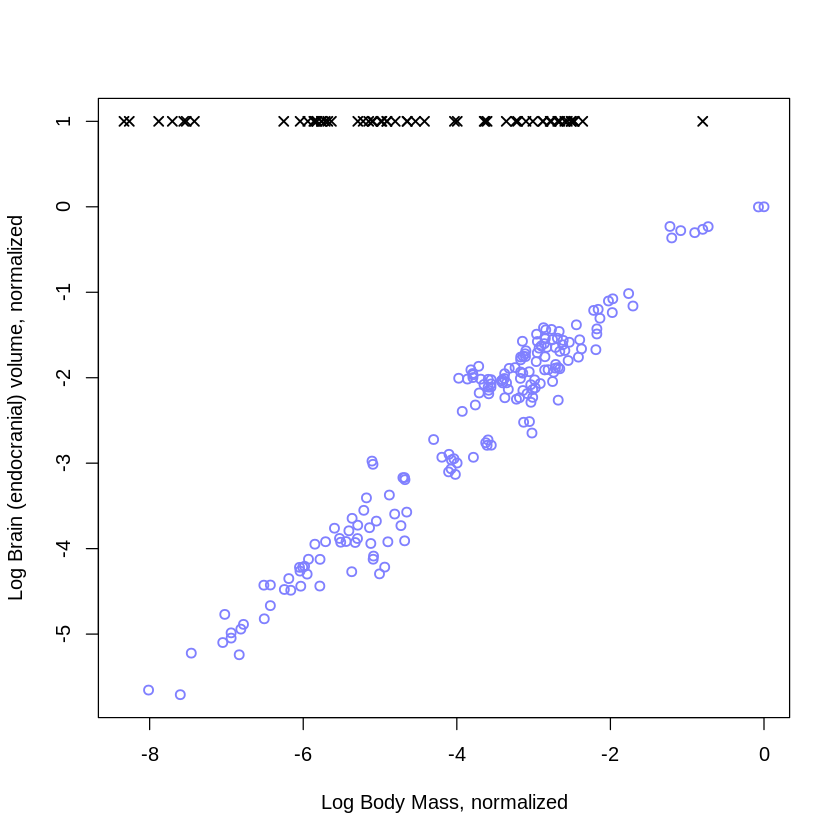

In [12]:
# symbol <- ifelse( B==1 , 16 , 1 )
# symbol <- ifelse( is.na(B) , 4 , symbol )
symbol <- ifelse( is.na(B) , 4 , 1 )
color <- ifelse( is.na(B) , "black" , rangi2 )
logB_replace <- ifelse( is.na(B), 1, log(B))
# plot( log(M) , log(B) , pch=symbol , col=color , xlab="Log Body Mass, normalized" , ylab="Log Brain (endocranial) volume, normalized" , lwd=1.5 )
plot( log(M) , logB_replace , pch=symbol , col=color , xlab="Log Body Mass, normalized" , ylab="Log Brain (endocranial) volume, normalized" , lwd=1.5 )

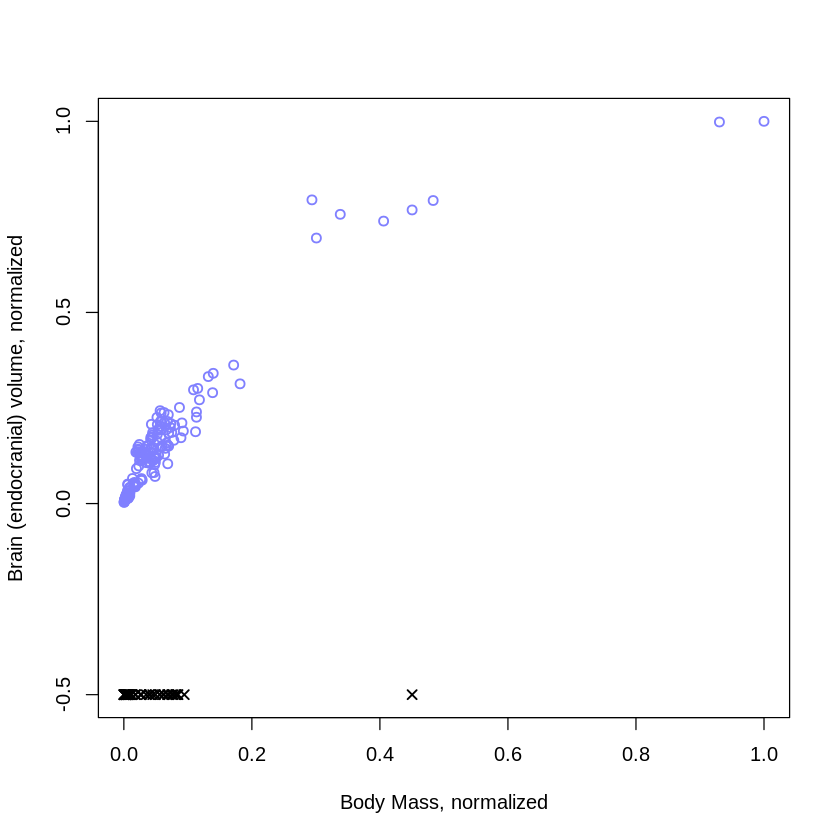

In [26]:
# symbol <- ifelse( is.na(B) , 4 , 1 )
# color <- ifelse( is.na(B) , "black" , rangi2 )
B_replace <- ifelse( is.na(B), -0.5, B)
plot( M , B_replace , pch=symbol , col=color , xlab="Body Mass, normalized" , ylab="Brain (endocranial) volume, normalized" , lwd=1.5 )

On the normal linear scale, it seems that the missing data is largely at body masses that are well covered by other species', i.e. we are not missing large ranges of body mass due to missing data.  This suggests the inputation should be able to do a good job of imputing the missing values of B (assuming the main determination of B is via M).

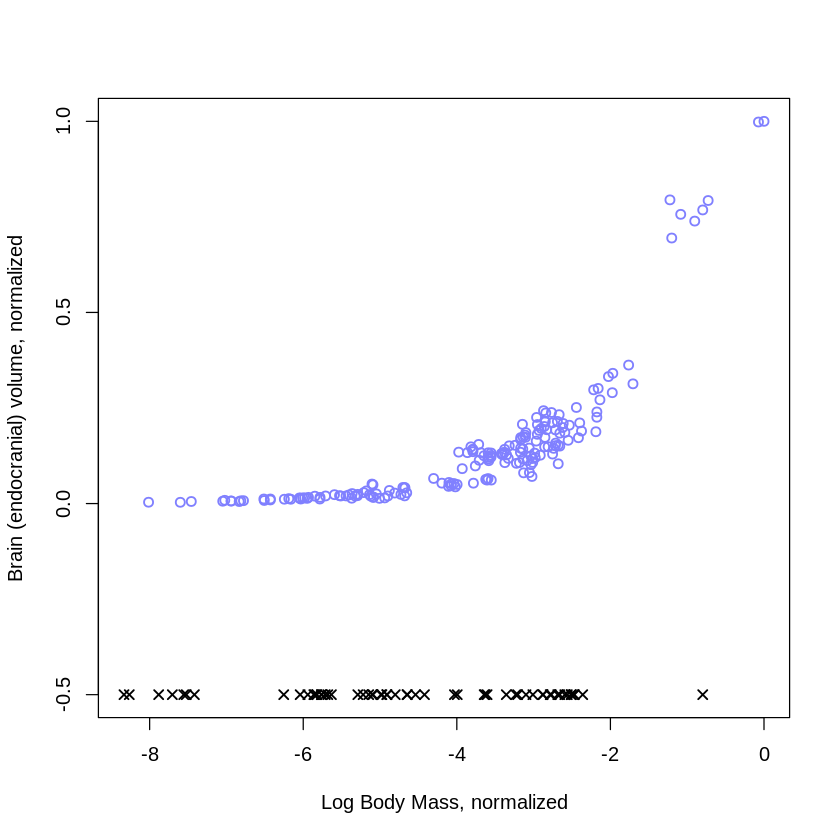

In [27]:
# symbol <- ifelse( is.na(B) , 4 , 1 )
# color <- ifelse( is.na(B) , "black" , rangi2 )
B_replace <- ifelse( is.na(B), -0.5, B)
plot( log(M) , B_replace , pch=symbol , col=color , xlab="Log Body Mass, normalized" , ylab="Brain (endocranial) volume, normalized" , lwd=1.5 )

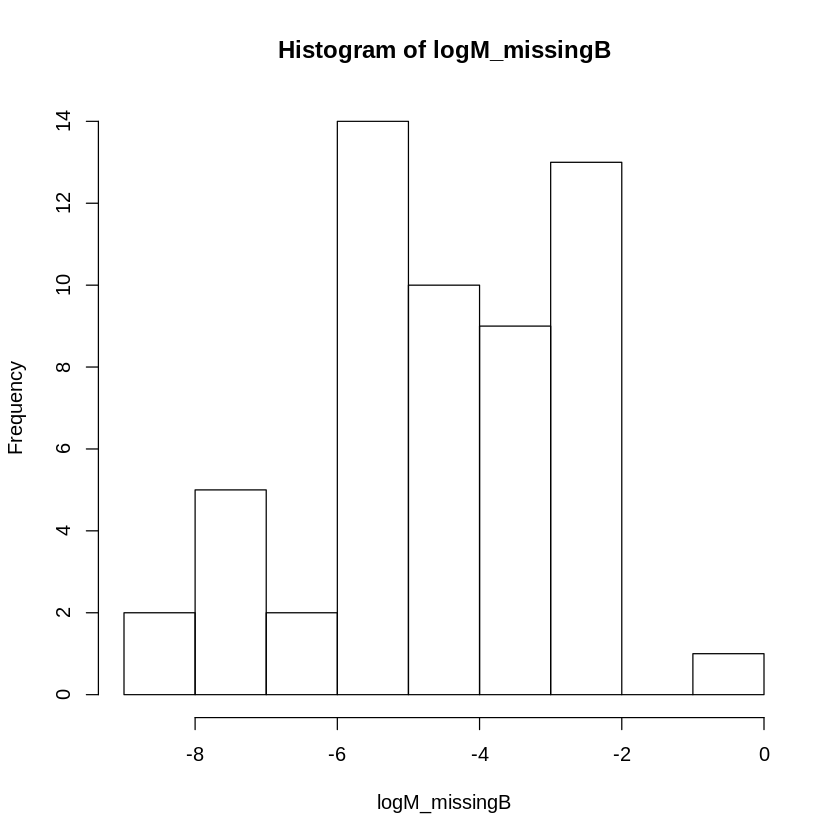

In [16]:
logM_missingB <- log(M[which(is.na(B))])
hist(logM_missingB)

In [17]:
maxBodyMass <- max(d$body[which(!is.na(d$body))])
maxBodyMass

[1] 130000

The missing Brain data tend to have values of M between the range exp(-6) = 0.0025 and exp(-2) = 0.135 on the normalized scale, and between exp(-6)*130000 = 320 grams and exp(-2)*130000 = 18 kg

Compare this to histogram of body masses with known brain size.  Ideally we would compare the distributions of with/without brain sizes.

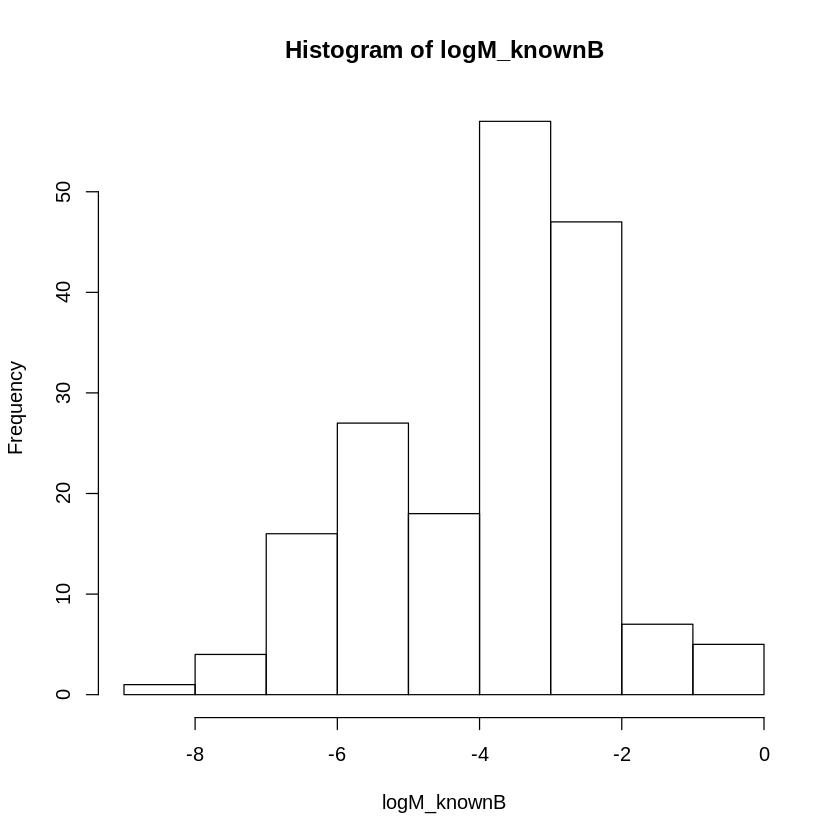

In [19]:
logM_knownB <- log(M[which(!is.na(B))])
hist(logM_knownB)

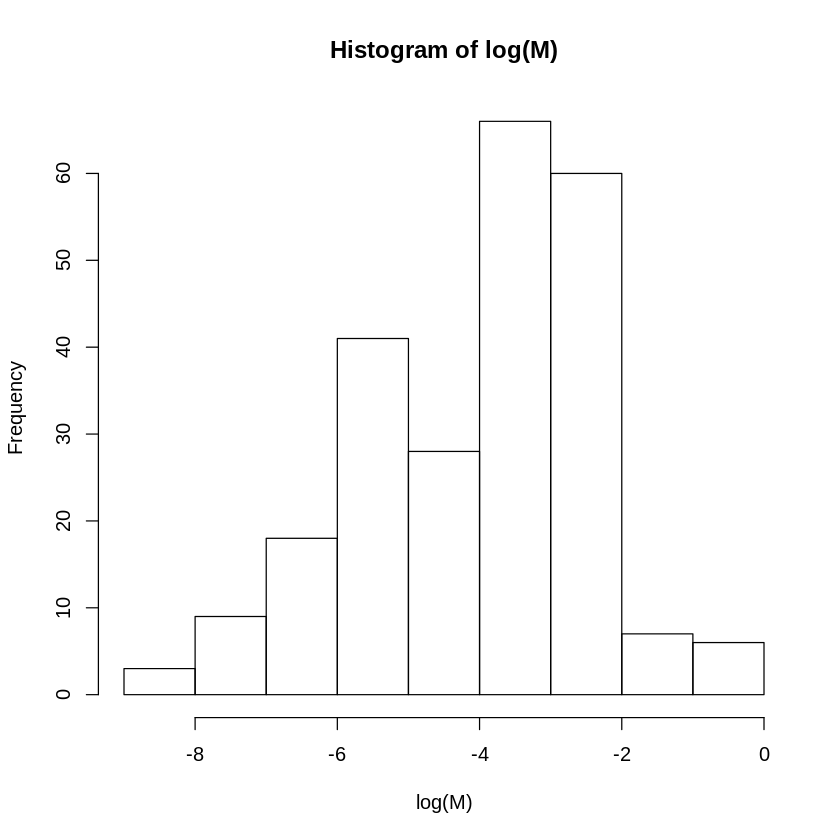

In [20]:
hist(log(M))

So although most missing brains occur for primates with log normalized body mass within -6 and -2, this is also the most common range of primate body mass, although between -4 and -2 is even more common body mass.  Perhaps the missing brain sizes are unusually high for primates with log normalized body mass between -6 (0.3kg) and -4 (2.4kg)


So we can hypothesize that body mass does indeed influence the missing data mechanism of brain size.

In this case, it would be Missing At Random (MAR) mechanism, because it is not 'Missing Completely At Random' (as we have a link between body mass and brain size missingness), and it is not 'Missing Not At Random' because it is not (necessarily in our hypothesis) brain size that influences the missingness of brain size.  

What could the mechanism be, that causes an exceptionally high amount of missing brain size data of primates between 0.3kg and 2.4kg?

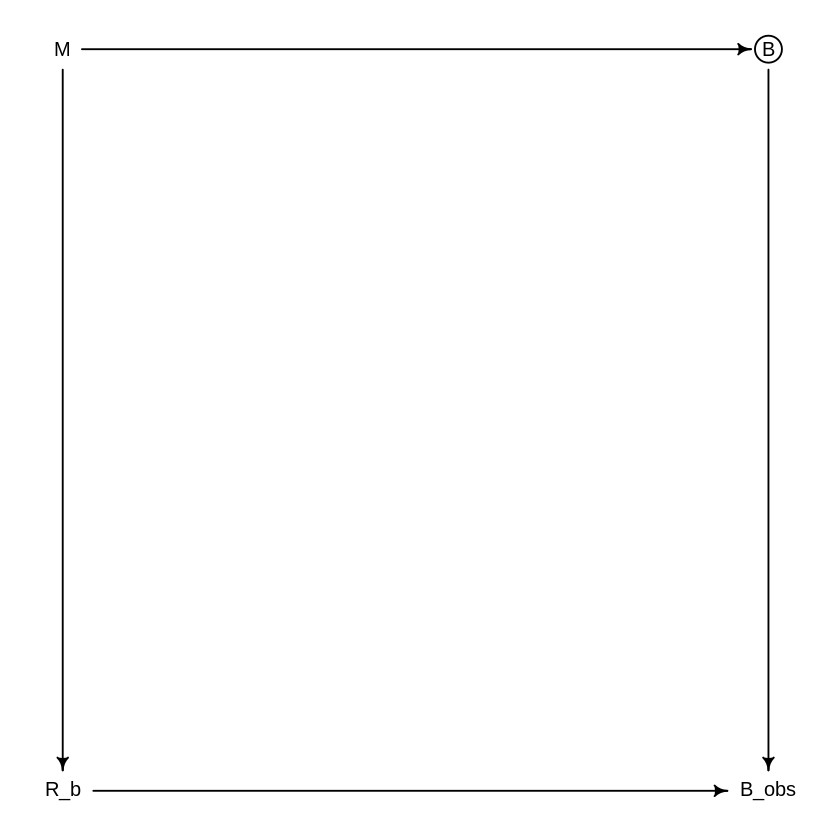

In [34]:
# library(dagitty)
# dag2 <- dagitty('dag{
#                     M -> R_B -> "B*" <- B
#                     M -> B
#                     }')

# coordinates(dag2) <- list( x=c(M=0,B=1,R_B=0,"B*"=1), y=c(M=0,B=0,R_B=1,"B*"=1) )
# drawdag( dag2 , shapes=list(B="c") )

library(dagitty)

primate_dag <- dagitty( "dag {
                                M -> B -> B_obs
                                M -> R_b -> B_obs
                                }")

coordinates( primate_dag ) <- list( x=c(M=0,B=1,B_obs=1,R_b=0) , y=c(M=0,B=0,B_obs=1,R_b=1) )
# plot( primate_dag )
drawdag( primate_dag , shapes=list(B="c") )        # Draws a circle around B to reflect that it is unobserved.

There is now a non-causal backdoor path from M to B_obs via R_b; to block it we should condition on M, but we want to condition on M anyway.

As the book says: "This doesn’t mean there is no danger here. If we get the functions or distributions wrong,
then we may get the wrong answer and the missing data may prevent us from seeing the
absurdity of it in posterior predictive checks. Suppose for example that studying doesn’t
help at all until a student does more than the average amount (0). In that case, we never get
to see homework from those students, so we can’t possibly figure out the function that relates
study effort to homework score."

In our case, the missing data is spread across the range of M in clumps.  Observing a plot of M against B for known values, the relationship is pretty linear correlated, and covers a wide range of M, such that the clumps of missing B values don't deny us knowledge of ranges of most values of M.  So I think the imputation should be reasonably successful.

In [19]:
dat = list(M=M, B=B)

m2 <- ulam(
            alist(

                B ~ dlnorm( mu , sigma ),
                mu <- a + b*log(M),
                a ~ normal(0,1),
                b ~ normal(0,1),
                sigma ~ exponential(1)
            ), 
            data=dat, cores=4, chains=4
            , start=list( B_impute=rep(0.5,56) )
        )

Found 56 NA values in B and attempting imputation.


In [23]:
precis(m2)

56 vector or matrix parameters hidden. Use depth=2 to show them.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.4266446,0.05647475,0.3361802,0.5159509,884.0858,1.002449
b,0.7828029,0.01350383,0.7614743,0.8047286,864.5532,1.002596
sigma,0.2932858,0.01571828,0.2698873,0.3192116,1168.8353,1.001477


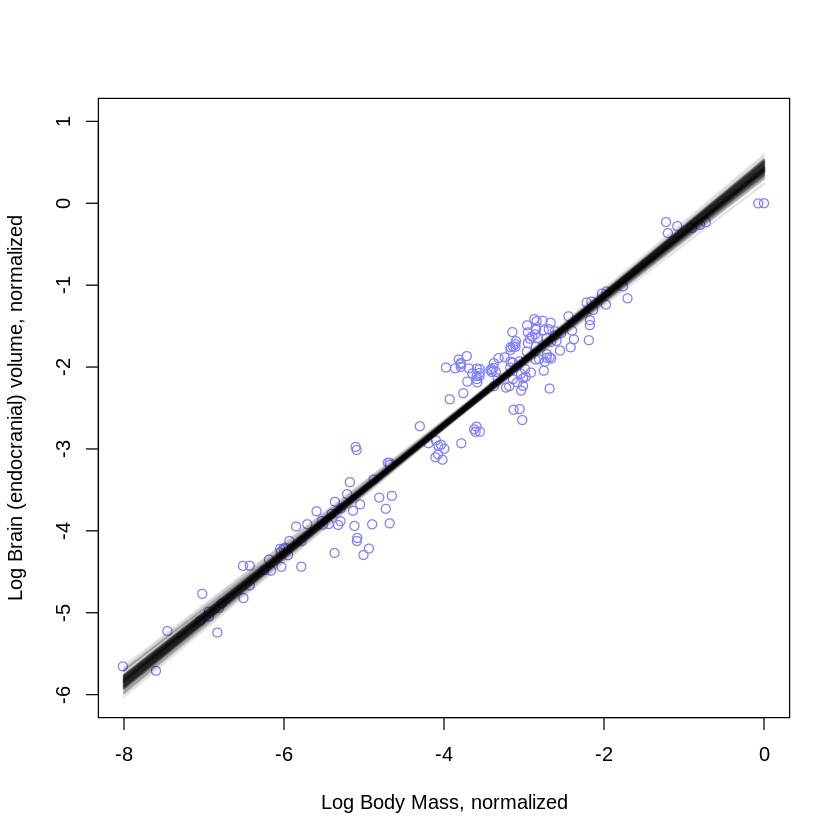

In [33]:
logM.seq <- seq( from=-8 , to=0 , by=0.1 )
post <- extract.samples(m2)

# Creates an error 'could not find function "merge_missing" when trying to run link()
# mu <- link( m2 , data=data.frame(M=exp(logM.seq)) )
# mu.mean <- apply( mu , 2 , mean )
# mu.CI <- apply( mu , 2 , HPDI , prob=0.89 )

plot( log(M) , log(B) , pch=symbol , col=color , xlab="Log Body Mass, normalized" , ylab="Log Brain (endocranial) volume, normalized", xlim=c(-8,0), ylim=c(-6,1) )
for (i in 1:100) lines( logM.seq , post$a[i] + post$b[i]*logM.seq , lwd=2 , col=col.alpha("black",0.1) )
# lines( logM.seq , mu.mean )
# shade( mu.CI , logM.seq )

In [3]:
# From the Homework solutions, another version of the model with explicit merge_missing.
# Unfortunately this also doesn't fix the merge_missing error when calling the link function in the plot creation above...
dat_list = list(M=M, B=B)

m2.1b <- ulam(
                alist(
                        B_merge ~ dlnorm( mu , sigma ),
                        mu <- a + b*log(M),
                        B_merge <- merge_missing( B , B_impute ),
                        a ~ normal(0,1),
                        b ~ normal(0,1),
                        sigma ~ exponential(1)
            ) ,
            data=dat_list , chains=4 , cores=4 ,
            start=list( B_impute = rep(0.5,56) ) )

Warning message:
“There were 4 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [4]:
precis( m2.1b )

56 vector or matrix parameters hidden. Use depth=2 to show them.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.4267377,0.06036018,0.3324408,0.5234620,859.9373,0.9992424
b,0.7831332,0.01456035,0.7606247,0.8072077,840.4887,0.9991218
sigma,0.2931080,0.01578655,0.2689103,0.3192626,1172.1414,1.0014727


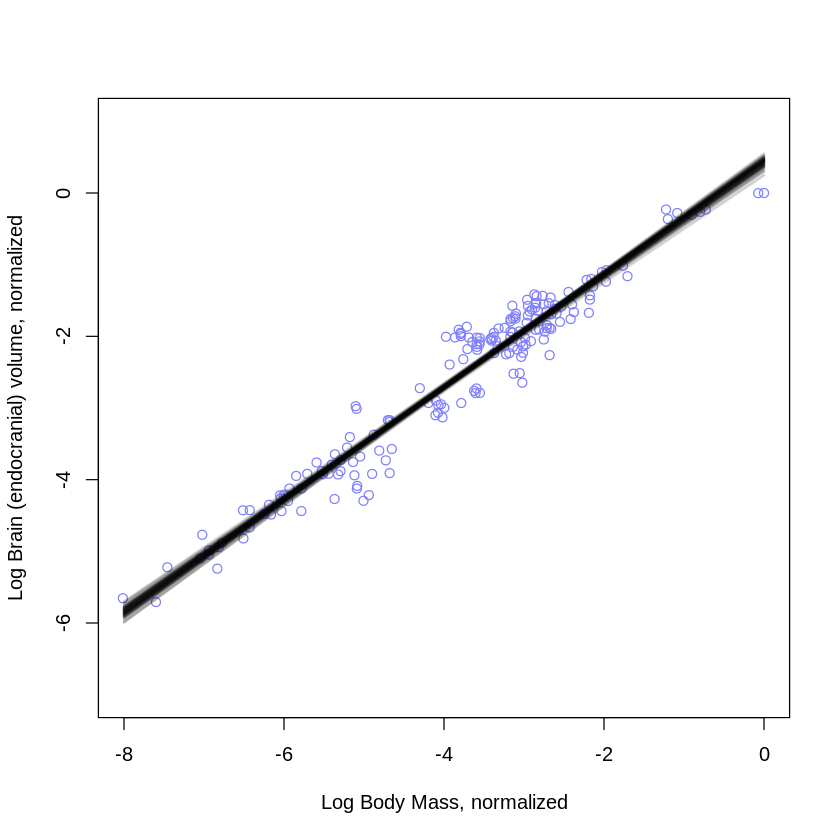

In [35]:
logM.seq <- seq( from=-8 , to=0 , by=0.1 )
post <- extract.samples(m2.1b)

# Creates an error 'could not find function "merge_missing" when trying to run link()
# mu <- link( m2.1b , data=data.frame(M=exp(logM.seq)) )
# mu.mean <- apply( mu , 2 , mean )
# mu.CI <- apply( mu , 2 , HPDI , prob=0.89 )

plot( log(M) , log(B) , pch=symbol , col=color , xlab="Log Body Mass, normalized" , ylab="Log Brain (endocranial) volume, normalized", xlim=c(-8,0), ylim=c(-7,1) )
for (i in 1:100) lines( logM.seq , post$a[i] + post$b[i]*logM.seq , lwd=2 , col=col.alpha("black",0.1) )
# lines( logM.seq , mu.mean )
# shade( mu.CI , logM.seq )

Compare to complete cases only model

In [30]:
cc2 <- complete.cases( B )
datCC <- list(M=M[cc2], B=B[cc2])

m2cc <- ulam(
            alist(

                B ~ dlnorm( mu , sigma ),
                mu <- a + b*log(M),
                a ~ normal(0,1),
                b ~ normal(0,1),
                sigma ~ exponential(1)
            ), 
            data=datCC, cores=4, chains=4
#             , control=list(max_treedepth=20, adapt_delta=0.99)
        )

recompiling to avoid crashing R session


In [31]:
precis(m2cc)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.4264080,0.06007125,0.3300588,0.5247548,798.5672,1.001812
b,0.7831768,0.01452159,0.7602303,0.8064426,757.4162,1.001235
sigma,0.2946040,0.01626189,0.2694896,0.3208928,1114.8742,1.002811


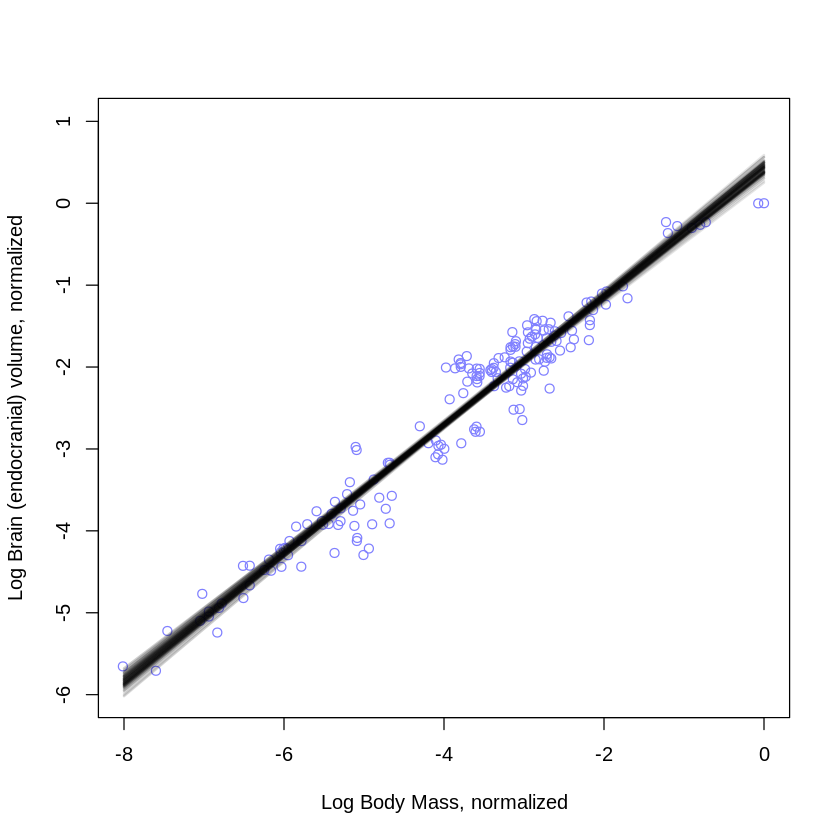

In [34]:
logM.seq <- seq( from=-8 , to=0 , by=0.1 )
postCC <- extract.samples(m2cc)
mu <- link( m2cc , data=data.frame(M=exp(logM.seq)) )
mu.mean <- apply( mu , 2 , mean )
mu.CI <- apply( mu , 2 , HPDI , prob=0.89 )

plot( log(M) , log(B) , pch=symbol , col=color , xlab="Log Body Mass, normalized" , ylab="Log Brain (endocranial) volume, normalized", xlim=c(-8,0), ylim=c(-6,1) )
for (i in 1:100) lines( logM.seq , postCC$a[i] + postCC$b[i]*logM.seq , lwd=2 , col=col.alpha("black",0.1) )
# lines( logM.seq , mu.mean )
# shade( mu.CI , logM.seq )

Let's insert the inputations now:

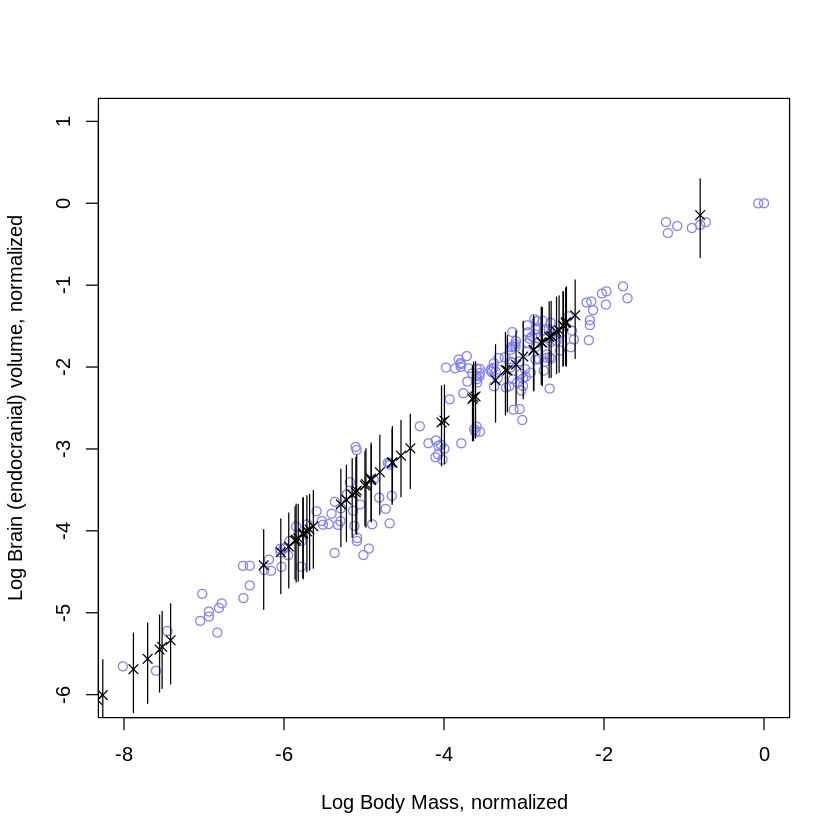

In [45]:
post <- extract.samples( m2 )
B_impute_mu <- apply( post$B_impute , 2 , mean )
B_impute_ci <- apply( post$B_impute , 2 , PI )

plot( log(M) , log(B) , pch=symbol , col=color , xlab="Log Body Mass, normalized" , ylab="Log Brain (endocranial) volume, normalized", xlim=c(-8,0), ylim=c(-6,1) )
miss_idx <- which( is.na(dat$B) )
Mi <- dat$M[miss_idx]
points( log(Mi), log(B_impute_mu), pch=4 )
for ( i in 1:N_miss ) lines( rep(log(Mi[i]),2) , log(B_impute_ci[,i]) )

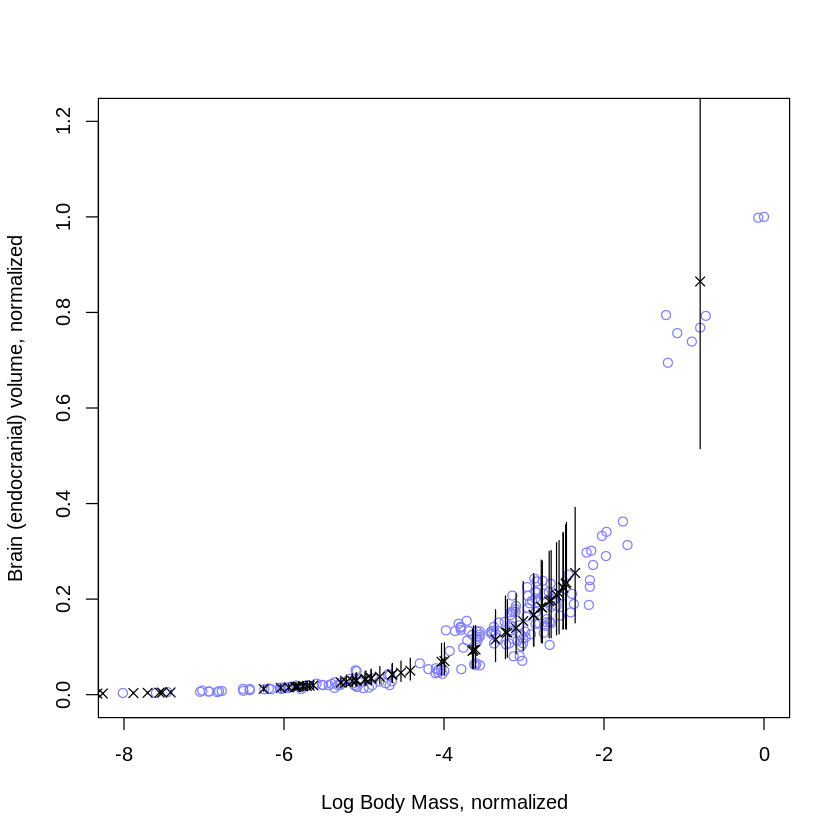

In [50]:
# post <- extract.samples( m2 )
# B_impute_mu <- apply( post$B_impute , 2 , mean )
# B_impute_ci <- apply( post$B_impute , 2 , PI )

plot( log(M) , B , pch=symbol , col=color , xlab="Log Body Mass, normalized" , ylab="Brain (endocranial) volume, normalized", xlim=c(-8,0), ylim=c(0,1.2) )
miss_idx <- which( is.na(dat$B) )
Mi <- dat$M[miss_idx]
points( log(Mi), B_impute_mu, pch=4 )
for ( i in 1:N_miss ) lines( rep(log(Mi[i]),2) , B_impute_ci[,i] )

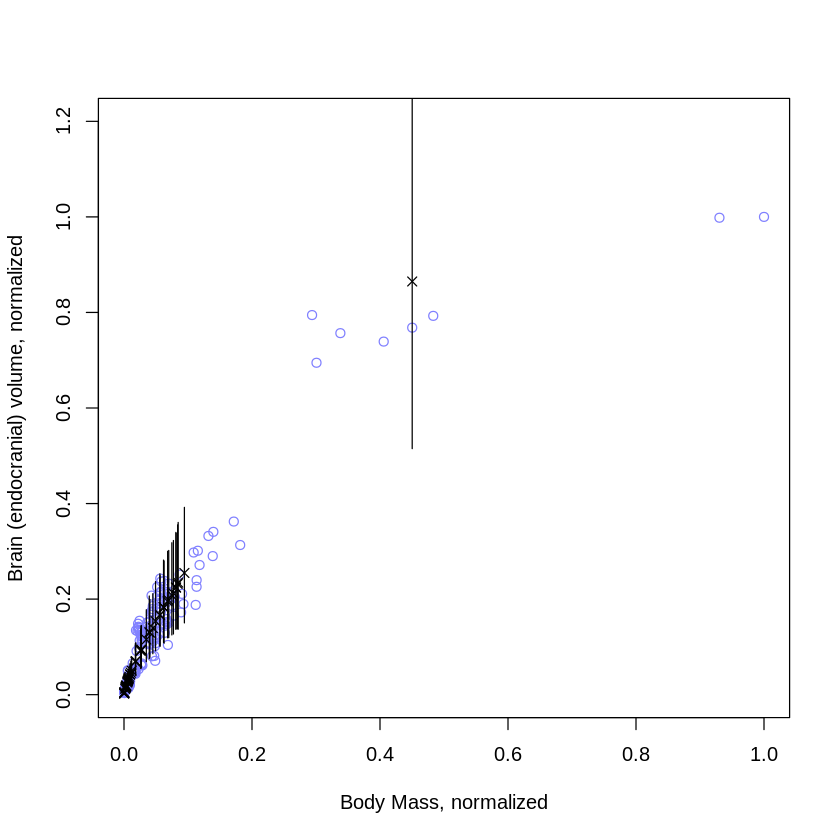

In [52]:
# post <- extract.samples( m2 )
# B_impute_mu <- apply( post$B_impute , 2 , mean )
# B_impute_ci <- apply( post$B_impute , 2 , PI )

plot( M , B , pch=symbol , col=color , xlab="Body Mass, normalized" , ylab="Brain (endocranial) volume, normalized", xlim=c(0,1), ylim=c(0,1.2) )
miss_idx <- which( is.na(dat$B) )
Mi <- dat$M[miss_idx]
points( Mi, B_impute_mu, pch=4 )
for ( i in 1:N_miss ) lines( rep(Mi[i],2) , B_impute_ci[,i] )

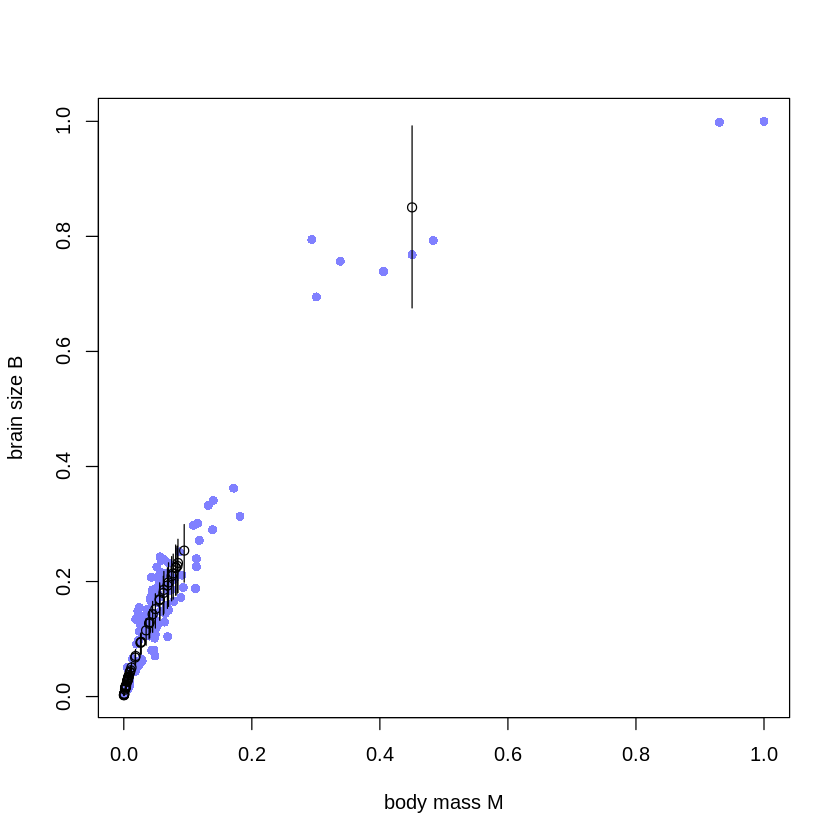

In [55]:
post <- extract.samples(m2.1b)
Bi <- apply( post$B_impute , 2 , mean )
miss_idx <- which( is.na(B) )
plot( M[-miss_idx] , B[-miss_idx] , col=rangi2 , pch=16 ,
xlab="body mass M" , ylab="brain size B" )
points( M[miss_idx] , Bi )
Bi_ci <- apply( post$B_impute , 2 , PI , 0.5 )    # 50% confidence interval, unlike the charts above that are 89%...
for ( i in 1:length(Bi) ) lines( rep(M[miss_idx][i],2) , Bi_ci[,i] )

From the homework solutions, "Imputation hasn’t done much, apparently because all but one of the missing values are in
a very dense region of the body size range. So almost no information was lost—the missing info is redundant."